In [31]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
from shapely import wkt
from cartoframes.viz import *
import os
import pickle

# 동 경계 데이터, 서울시 도로 데이터 불러오기

## 1. 동 데이터 가져오기

In [32]:
# 데이터 로드(424개 행정구역 업로드)   -> 이 데이터에는 빈부분이 존재....
dong_boundary = gpd.read_file('../emd/BND_ADM_DONG_PG.shp', encoding='CP949')
dong = dong_boundary[dong_boundary['ADM_CD'].str.startswith('11')]   # 서울시내 동 정보 추출

dong['ADM_CD'] = dong['ADM_CD'].astype(str)

# 중복이름 동 방지
dong.loc[(dong['ADM_NM']=='신사동') & (dong['ADM_CD']=='11230510'), 'ADM_NM'] = '신사동(강남)'
dong.loc[(dong['ADM_NM']=='신사동') & (dong['ADM_CD']=='11210680'), 'ADM_NM'] = '신사동(관악)'

# ============================== 424 데이터와 맞춰주기 ============================================
# 상일동 처리
sangil_union = dong[dong["ADM_NM"].isin(["상일1동", "상일2동"])]["geometry"].unary_union
# 상일1동 -> 상일동
dong.loc[dong['ADM_NM']=='상일1동', 'ADM_NM'] = '상일동'
dong.loc[dong['ADM_NM']=='상일동', 'geometry'] = sangil_union
# 상일2동 제거
dong = dong[~dong["ADM_NM"].isin(["상일2동"])]

# 개포3동 -> 일원2동 변경
dong.loc[dong['ADM_NM']=='개포3동', 'ADM_NM'] = '일원2동'

# 항동을 오류2동에 포함
oru2_union = dong[dong["ADM_NM"].isin(["항동", "오류2동"])]["geometry"].unary_union
# 오류2동 좌표 변경
dong.loc[dong['ADM_NM']=='오류2동', 'geometry'] = oru2_union
# 항동 제거
dong = dong[~dong["ADM_NM"].isin(["항동"])]
# =================================================================================================

# CRS 변환
dong.to_crs(epsg=4326, inplace=True)

# 쓸모없는 열 제거
dong = dong.drop(columns=['BASE_DATE', 'ADM_CD'])

# 결과 확인
print(dong.crs)
print(dong.shape)

EPSG:4326
(424, 2)


/home/hj/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## 2. 동별 도로 네트워크 불러오기

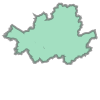

In [33]:
# 서울시 중심 좌표를 기준으로 경계 불러오기
seoul_boundary = dong.unary_union   # 모든 동의 경계를 합쳐서 서울시 경계 생성
seoul_boundary

In [34]:
layer_dong = Layer(dong,
                    basic_style(opacity=0.2), # 투명도
                    popup_hover=popup_element('ADM_NM', title='동이름')) # 얹으면 팝업

#layer_dong

In [35]:
# 2. 서울시 전체 도로 네트워크 불러오기
G_seoul = ox.graph_from_polygon(seoul_boundary, network_type='drive')

In [36]:
# 서울시내 도로 네트워크 정보 저장
nodes, edges = ox.graph_to_gdfs(G_seoul)

In [37]:
from cartoframes.viz import *

layer_seoul = Layer(edges,
                    basic_style(opacity=0.2),
                    popup_hover=popup_element('name', title='도로명')) # 얹으면 팝업

#Map(layers=[layer_seoul, layer_dong])

### 도로 전처리

In [38]:
# 노드 정보 확인
nodes.head()

y           x  street_count highway  ref  \
osmid                                                         
266813237  37.526615  127.000794             3     NaN  NaN   
278159482  37.525964  126.997422             3     NaN  NaN   
278159676  37.527696  127.002375             3     NaN  NaN   
282723724  37.588055  127.023541             3     NaN  NaN   
282723780  37.586624  127.025199             3     NaN  NaN   

                             geometry  
osmid                                  
266813237  POINT (127.00079 37.52662)  
278159482  POINT (126.99742 37.52596)  
278159676  POINT (127.00238 37.52770)  
282723724  POINT (127.02354 37.58805)  
282723780  POINT (127.02520 37.58662)

In [39]:
# 간선 정보 확인
edges.head()

osmid    name      highway  oneway reversed  \
u         v          key                                                    
266813237 3771909762 0    373776969  보광로12길  residential   False    False   
          436847094  0    373776969  보광로12길  residential   False     True   
          3771899749 0    373776966  보광로14길  residential   False    False   
278159482 1378780898 0     25524218   보광로7길  residential   False    False   
          1378780857 0     97836950     장문로     tertiary   False    False   

                          length  \
u         v          key           
266813237 3771909762 0    27.605   
          436847094  0    20.002   
          3771899749 0    69.877   
278159482 1378780898 0    66.892   
          1378780857 0    22.683   

                                                                   geometry  \
u         v          key                                                      
266813237 3771909762 0    LINESTRING (127.00079 37.52662, 127.00109 37.5...   
          436847094  0    LINESTRING (127.00079 37.52662, 127.00062 37.5...   
          3771899749 0    LINESTRING (127.00079 37.52662, 127.00059 37.5...   
278159482 1378780898 0    LINESTRING (126.99742 37.52596, 126.99813 37.5...   
          1378780857 0    LINESTRING (126.99742 37.52596, 126.99717 37.5...   

                         lanes maxspeed  ref bridge tunnel junction access  \
u         v          key                                                     
266813237 3771909762 0     NaN      NaN  NaN    NaN    NaN      NaN    NaN   
          436847094  0     NaN      NaN  NaN    NaN    NaN      NaN    NaN   
          3771899749 0     NaN      NaN  NaN    NaN    NaN      NaN    NaN   
278159482 1378780898 0     NaN      NaN  NaN    NaN    NaN      NaN    NaN   
          1378780857 0     NaN      NaN  NaN    NaN    NaN      NaN    NaN   

                         width service  
u         v          key                
266813237 3771909762 0     NaN     NaN  
          436847094  0     NaN     NaN  
          3771899749 0     NaN     NaN  
278159482 1378780898 0     NaN     NaN  
          1378780857 0     NaN     NaN

In [40]:
# null 값 개수
nan_counts = edges.isna().sum()
print(nan_counts)
print(f"전체 도로 개수: {len(edges)}")

# 전체 개수에 비해 null인 값이 너무 많다. -> [osmid, name, highway, oneway, length, geometry, bridge, tunnel] 정도만 살리고 나머지 제거

osmid            0
name         16673
highway          0
oneway           0
reversed         0
length           0
geometry         0
lanes       175550
maxspeed    184489
ref         182933
bridge      187951
tunnel      188902
junction    189390
access      188923
width       189315
service     189530
dtype: int64
전체 도로 개수: 189532


In [41]:
# 사용할 정보만 가져오기
new_edges = edges[['osmid', 'name', 'highway', 'oneway', 'length', 'geometry', 'bridge', 'tunnel']]
new_edges.head()

osmid    name      highway  oneway  length  \
u         v          key                                                   
266813237 3771909762 0    373776969  보광로12길  residential   False  27.605   
          436847094  0    373776969  보광로12길  residential   False  20.002   
          3771899749 0    373776966  보광로14길  residential   False  69.877   
278159482 1378780898 0     25524218   보광로7길  residential   False  66.892   
          1378780857 0     97836950     장문로     tertiary   False  22.683   

                                                                   geometry  \
u         v          key                                                      
266813237 3771909762 0    LINESTRING (127.00079 37.52662, 127.00109 37.5...   
          436847094  0    LINESTRING (127.00079 37.52662, 127.00062 37.5...   
          3771899749 0    LINESTRING (127.00079 37.52662, 127.00059 37.5...   
278159482 1378780898 0    LINESTRING (126.99742 37.52596, 126.99813 37.5...   
          1378780857 0    LINESTRING (126.99742 37.52596, 126.99717 37.5...   

                         bridge tunnel  
u         v          key                
266813237 3771909762 0      NaN    NaN  
          436847094  0      NaN    NaN  
          3771899749 0      NaN    NaN  
278159482 1378780898 0      NaN    NaN  
          1378780857 0      NaN    NaN

In [42]:
cols = new_edges.columns
for col in cols:
    print(edges[col].value_counts())

osmid
183272323                              74
37403279                               66
218681391                              64
198564928                              62
37399402                               62
                                       ..
518705246                               1
330258692                               1
520474615                               1
520731344                               1
[1339768064, 379795872, 1062637071]     1
Name: count, Length: 47735, dtype: int64
name
남부순환로                      597
통일로                        501
한천로                        424
동일로                        416
삼양로                        412
                          ... 
[은평로13길, 서오릉로]               1
[삼선교로16길, 삼선교로14길]           1
[선유로27길, 선유로25길]             1
금호 어울림아파트                    1
[성암로3가길, 성암로3길, 성암로3나길]      1
Name: count, Length: 13268, dtype: int64
highway
residential                             146500
secondary                                16865
te

* highway 전처리

In [43]:
# 도로 우선순위를 설정 (우선순위가 높을수록 중요한 도로)
highway_priority = {
    'motorway': 1,
    'motorway_link': 2,
    'trunk': 3,
    'trunk_link': 4,
    'primary': 5,
    'primary_link': 6,
    'secondary': 7,
    'secondary_link': 8,
    'tertiary': 9,
    'tertiary_link': 10,
    'unclassified': 11,
    'residential': 12,
    'living_street': 13,
    'service': 14,
    'pedestrian': 15,
    'track': 16,
    'path': 17
}

# 여러 개의 highway 값을 가진 행에 대해 우선순위가 높은 값 선택
def select_primary_highway(highway):
    # highway가 리스트 형식일 경우
    if isinstance(highway, list):
        # 우선순위에 따라 정렬하고 가장 우선순위가 높은 값 반환
        return sorted(highway, key=lambda x: highway_priority.get(x, float('inf')))[0]
    return highway  # 단일 값이면 그대로 반환

# highway 열을 업데이트하여 단일 값으로 통일
new_edges['highway'] = new_edges['highway'].apply(lambda x: select_primary_highway(x) if isinstance(x, list) else x)

print(new_edges['highway'].value_counts())

highway
residential       146524
secondary          16900
tertiary           10831
primary             6819
living_street       2688
secondary_link      1566
busway               943
trunk_link           892
primary_link         823
unclassified         697
trunk                453
tertiary_link        290
motorway_link         78
motorway              19
road                   4
crossing               4
disused                1
Name: count, dtype: int64


/home/hj/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [44]:
# 변환 후 리스트 형태의 값이 남아있는지 확인
# print(edges[edges['highway'].apply(lambda x: isinstance(x, list))])

In [45]:
print(new_edges['highway'].dtype)

object


* bridge 전처리

In [46]:
def categorize_bridge(value):
    if isinstance(value, list):
        # 리스트에 'viaduct'가 있으면 2 (고가도로), 'yes'만 있으면 1 (일반 다리)
        if 'viaduct' in value:
            return 2
        elif 'yes' in value:
            return 1
    elif value == 'viaduct':
        return 2  # 고가도로
    elif value == 'yes':
        return 1  # 일반 다리
    return 0  # 다리 정보 없음

# bridge 열 변환 적용
new_edges['bridge'] = new_edges['bridge'].apply(categorize_bridge)

print(new_edges['bridge'].value_counts())

bridge
0    187953
1      1540
2        39
Name: count, dtype: int64


/home/hj/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


* tunnel 전처리

In [47]:
# 터널 유형을 0, 1, 2로 구분하는 함수 정의
def categorize_tunnel(value):
    if value == 'building_passage':
        return 2  # 건물 통과 구간
    elif value == 'yes':
        return 1  # 일반 터널
    return 0  # 터널 정보 없음

# tunnel 열 변환 적용
new_edges['tunnel'] = new_edges['tunnel'].apply(categorize_tunnel)

# 변환 결과 확인
print(new_edges['tunnel'].value_counts())


tunnel
0    188902
1       601
2        29
Name: count, dtype: int64


### 동별 도로 배정

In [48]:
# 인접 동 리스트를 저장할 컬럼 추가
neighbors = {}

dong.to_crs(epsg=5179, inplace=True)

# 각 동에 대해 다른 동들과 비교하여 인접 동 계산
for idx, row in dong.iterrows():
    dong_name = row['ADM_NM']      # 현재 동의 이름
    current_geom = row['geometry'] # 현재 동의 지리정보
    friends = dong[(dong.geometry.intersects(current_geom)) & (dong['ADM_NM'] != dong_name)]['ADM_NM'].tolist()  # 인접 조건: 경계가 닿는 동들
    
    neighbors[dong_name] = friends

neighbors

{'사직동': ['무악동', '청운효자동', '소공동', '명동', '교남동', '종로1·2·3·4가동'],
 '삼청동': ['부암동', '성북동', '청운효자동', '혜화동', '가회동', '종로1·2·3·4가동'],
 '부암동': ['삼청동', '평창동', '성북동', '청운효자동', '홍제3동', '홍은1동'],
 '평창동': ['부암동', '정릉4동', '성북동', '진관동', '정릉3동', '불광1동', '홍은1동'],
 '한남동': ['옥수동',
  '장충동',
  '이태원1동',
  '보광동',
  '다산동',
  '약수동',
  '이태원2동',
  '잠원동',
  '신사동(강남)'],
 '왕십리2동': ['금호1가동', '신당5동', '동화동', '행당1동', '행당2동', '왕십리도선동'],
 '마장동': ['사근동', '용답동', '행당1동', '왕십리도선동', '용신동'],
 '중림동': ['충현동', '소공동', '회현동', '청파동', '공덕동'],
 '옥수동': ['한남동', '금호4가동', '성수1가1동', '약수동', '금호2·3가동', '신사동(강남)', '압구정동'],
 '장충동': ['한남동', '광희동', '용산2가동', '필동', '신당동', '다산동', '이태원2동'],
 '광희동': ['장충동', '종로5·6가동', '을지로동', '필동', '신당동'],
 '사근동': ['마장동', '송정동', '용답동', '행당1동', '응봉동', '성수1가2동'],
 '후암동': ['용산2가동', '남영동', '회현동', '필동'],
 '용산2가동': ['장충동', '후암동', '남영동', '이태원1동', '필동', '서빙고동', '한강로동', '이태원2동'],
 '남영동': ['후암동', '용산2가동', '회현동', '청파동', '원효로1동', '한강로동'],
 '원효로2동': ['용문동', '원효로1동', '한강로동', '이촌2동', '도화동', '여의동'],
 '효창동': ['용문동', '청파동', '원효로1동', '공덕동',

In [49]:
# 동별 동내 도로 데이터를 저장할 딕셔너리 생성
dong.to_crs(epsg=4326, inplace=True)

dong_road_dataframes = {}

# 각 도로가 포함된 동을 확인하여 동별로 분류
for idx, row in dong.iterrows():
    dong_name = row['ADM_NM']
    dong_boundary = row['geometry']
    
    # 동 경계에 포함된 도로 필터링
    roads_in_dong = new_edges[new_edges['geometry'].within(dong_boundary)]
    
    # 동 이름을 키로 사용하여 도로 데이터프레임을 저장
    dong_road_dataframes[dong_name] = roads_in_dong.reset_index(drop=True)

In [50]:
# 확인
dong_road_dataframes['사직동']

osmid    name      highway  oneway   length  \
0     919985573  새문안로3길  residential   False    5.927   
1     919985574    새문안로      primary    True  168.025   
2     180793307    새문안로  residential   False   69.998   
3      37399752   사직로8길     tertiary   False  157.510   
4      37399752   사직로8길     tertiary   False  219.576   
..          ...     ...          ...     ...      ...   
209  1322056285     NaN       busway    True  399.097   
210   198566325    세종대로      primary    True    4.264   
211  1322056285     NaN       busway    True   14.384   
212   621513148     NaN       busway    True   59.296   
213  1322064593     NaN       busway    True   99.892   

                                              geometry  bridge  tunnel  
0    LINESTRING (126.97255 37.57005, 126.97255 37.5...       0       0  
1    LINESTRING (126.97255 37.57005, 126.97446 37.5...       0       0  
2    LINESTRING (126.97255 37.57005, 126.97267 37.5...       0       0  
3    LINESTRING (126.97269 37.57404, 126.97344 37.5...       0       0  
4    LINESTRING (126.97269 37.57404, 126.97210 37.5...       0       0  
..                                                 ...     ...     ...  
209  LINESTRING (126.97707 37.57024, 126.97690 37.5...       0       0  
210  LINESTRING (126.97724 37.57024, 126.97724 37.5...       0       0  
211  LINESTRING (126.97724 37.57024, 126.97707 37.5...       0       0  
212  LINESTRING (126.97005 37.56895, 126.96949 37.5...       0       0  
213  LINESTRING (126.97005 37.56895, 126.96932 37.5...       0       0  

[214 rows x 8 columns]

In [51]:
# 시각화
l1 = Layer(dong_road_dataframes['사직동'], basic_style(opacity=0.8), # 투명도
                    popup_hover=popup_element('name', title='도로명')) # 얹으면 팝업

l2 = Layer(dong, basic_style(opacity=0.2), popup_hover=popup_element('ADM_NM', title='Region')) # 투명도

#Map([l1, l2])

In [52]:
# 동별 도로 임베딩을 저장할 데이터프레임 초기화
dong_embeddings = []

for dong_name, roads_df in dong_road_dataframes.items():
    # 1. 도로 개수
    road_count = len(roads_df)
    
    # 2. highway 값별 개수
    #print(dong_name)
    #print(roads_df[roads_df['highway'].apply(lambda x: isinstance(x, list))])
    highway_counts = roads_df['highway'].value_counts().to_dict()
    
    # 3. 총 길이
    total_length = roads_df['length'].sum()
    
    # 4. 터널 개수 (일반 터널과 건물 통과 구간)
    tunnel_counts = roads_df['tunnel'].value_counts().reindex([1, 2], fill_value=0).to_dict()
    
    # 5. 다리 개수 (일반 다리와 고가도로)
    bridge_counts = roads_df['bridge'].value_counts().reindex([1, 2], fill_value=0).to_dict()
    
    # 6. 임베딩 벡터 구성
    embedding = {
        'ADM_NM': dong_name,
        'road_count': road_count,
        'total_length': total_length,
        'tunnel_count_general': tunnel_counts.get(1, 0),
        'tunnel_count_building_passage': tunnel_counts.get(2, 0),
        'bridge_count_general': bridge_counts.get(1, 0),
        'bridge_count_viaduct': bridge_counts.get(2, 0)
    }
    
    # highway별 개수를 임베딩에 추가
    for highway_type, count in highway_counts.items():
        embedding[f'highway_count_{highway_type}'] = count
    
    # 동별 임베딩 리스트에 추가
    dong_embeddings.append(embedding)

# 동별 임베딩 데이터프레임 생성
dong_embeddings_df = pd.DataFrame(dong_embeddings).fillna(0)  # NaN 값은 0으로 채움

# 결과 확인
dong_embeddings_df.head()

ADM_NM  road_count  total_length  tunnel_count_general  \
0    사직동         214     22040.495                     0   
1    삼청동          17      3477.422                     0   
2    부암동         375     36188.775                     0   
3    평창동         717     74985.331                     0   
4    한남동        1140     80463.446                     2   

   tunnel_count_building_passage  bridge_count_general  bridge_count_viaduct  \
0                              0                     0                     0   
1                              0                     0                     0   
2                              0                    14                     0   
3                              0                     4                     0   
4                              0                     5                     0   

   highway_count_residential  highway_count_primary  highway_count_tertiary  \
0                       84.0                   45.0                    30.0   
1                        9.0                    2.0                     6.0   
2                      295.0                   12.0                    28.0   
3                      675.0                   37.0                     0.0   
4                      952.0                   34.0                    44.0   

   ...  highway_count_primary_link  highway_count_secondary  \
0  ...                         6.0                      0.0   
1  ...                         0.0                      0.0   
2  ...                         2.0                     24.0   
3  ...                         0.0                      0.0   
4  ...                         2.0                     72.0   

   highway_count_secondary_link  highway_count_unclassified  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           1.0                         0.0   
3                           5.0                         0.0   
4                          31.0                         2.0   

   highway_count_trunk  highway_count_trunk_link  highway_count_motorway_link  \
0                  0.0                       0.0                          0.0   
1                  0.0                       0.0                          0.0   
2                  0.0                       0.0                          0.0   
3                  0.0                       0.0                          0.0   
4                  1.0                       0.0                          0.0   

   highway_count_crossing  highway_count_road  highway_count_motorway  
0                     0.0                 0.0                     0.0  
1                     0.0                 0.0                     0.0  
2                     0.0                 0.0                     0.0  
3                     0.0                 0.0                     0.0  
4                     0.0                 0.0                     0.0  

[5 rows x 23 columns]

In [53]:
dong.head()

ADM_NM                                           geometry
0    사직동  POLYGON ((126.97399 37.57823, 126.97400 37.578...
1    삼청동  POLYGON ((126.97929 37.58349, 126.97931 37.583...
2    부암동  POLYGON ((126.96173 37.60714, 126.96182 37.607...
3    평창동  POLYGON ((126.97508 37.63118, 126.97488 37.630...
4    한남동  POLYGON ((127.00457 37.54980, 127.00457 37.549...

In [54]:
# 동별 연결된 동과의 도로 개수 저장 ex) 사직동 -> [(무악동, 2), (종로1·2·3·4가동, 3)..] -> 이거 자체로 edge가 된다!
connections = {}

dong.to_crs(epsg=5179, inplace=True)
new_edges.to_crs(epsg=5179, inplace=True)

for start, targets in neighbors.items():
    dong_boundary = dong.loc[dong['ADM_NM']==start, 'geometry'].values[0]   # 시작동 경계
    
    # 이웃한 동들 도로개수 계산
    for target in targets:
        target_boundary = dong.loc[dong['ADM_NM']==target, 'geometry'].values[0]
        
        # 공유하는 도로의 개수 확인
        connecting_roads = new_edges[new_edges['geometry'].intersects(dong_boundary) &
                                     new_edges['geometry'].intersects(target_boundary)]
        connected_counts = len(connecting_roads)  # 공유 도로 개수
        
        # 업데이트
        if start not in connections:
            connections[start] = []
        if connected_counts == 0:
            connected_counts = 0.1   # 인접성 정보 유지
        connections[start].append([target, connected_counts])
        

/home/hj/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [55]:
dong.to_crs(epsg=4326, inplace=True)
new_edges.to_crs(epsg=4326, inplace=True)
connections

/home/hj/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


{'사직동': [['무악동', 2],
  ['청운효자동', 15],
  ['소공동', 6],
  ['명동', 4],
  ['교남동', 9],
  ['종로1·2·3·4가동', 11]],
 '삼청동': [['부암동', 0.1],
  ['성북동', 2],
  ['청운효자동', 13],
  ['혜화동', 4],
  ['가회동', 8],
  ['종로1·2·3·4가동', 9]],
 '부암동': [['삼청동', 0.1],
  ['평창동', 17],
  ['성북동', 2],
  ['청운효자동', 6],
  ['홍제3동', 4],
  ['홍은1동', 2]],
 '평창동': [['부암동', 17],
  ['정릉4동', 0.1],
  ['성북동', 6],
  ['진관동', 0.1],
  ['정릉3동', 6],
  ['불광1동', 2],
  ['홍은1동', 4]],
 '한남동': [['옥수동', 6],
  ['장충동', 5],
  ['이태원1동', 26],
  ['보광동', 32],
  ['다산동', 4],
  ['약수동', 4],
  ['이태원2동', 13],
  ['잠원동', 0.1],
  ['신사동(강남)', 4]],
 '왕십리2동': [['금호1가동', 6],
  ['신당5동', 9],
  ['동화동', 0.1],
  ['행당1동', 18],
  ['행당2동', 16],
  ['왕십리도선동', 14]],
 '마장동': [['사근동', 28], ['용답동', 2], ['행당1동', 10], ['왕십리도선동', 26], ['용신동', 5]],
 '중림동': [['충현동', 15], ['소공동', 11], ['회현동', 0.1], ['청파동', 13], ['공덕동', 20]],
 '옥수동': [['한남동', 6],
  ['금호4가동', 31],
  ['성수1가1동', 9],
  ['약수동', 5],
  ['금호2·3가동', 3],
  ['신사동(강남)', 1],
  ['압구정동', 4]],
 '장충동': [['한남동', 5],
  ['광희동', 38],
  ['용산2가동', 1]

In [56]:
# 동별 면적 계산
dong.to_crs(epsg=5179, inplace=True)
dong_area = dong.copy()
dong_area['area'] = dong_area['geometry'].area 

# 최종 동 임베딩 생성
dong_info = dong_embeddings_df.merge(dong_area[['ADM_NM', 'area']], on='ADM_NM', how='inner')

# 동 임베딩 저장
dong_info.to_csv('../Dataset/Raw_Embeddings/Road_Embeddings.csv', index=False)

dong_info

ADM_NM  road_count  total_length  tunnel_count_general  \
0            사직동         214     22040.495                     0   
1            삼청동          17      3477.422                     0   
2            부암동         375     36188.775                     0   
3            평창동         717     74985.331                     0   
4            한남동        1140     80463.446                     2   
..           ...         ...           ...                   ...   
419          가회동          43      4359.330                     0   
420  종로1·2·3·4가동         764     55584.225                    16   
421         방배2동         570     39767.126                     1   
422          미아동         976     43446.065                     0   
423          인수동        1360     67067.752                     0   

     tunnel_count_building_passage  bridge_count_general  \
0                                0                     0   
1                                0                     0   
2                                0                    14   
3                                0                     4   
4                                0                     5   
..                             ...                   ...   
419                              0                     0   
420                              0                     0   
421                              0                     0   
422                              0                     0   
423                              0                     2   

     bridge_count_viaduct  highway_count_residential  highway_count_primary  \
0                       0                       84.0                   45.0   
1                       0                        9.0                    2.0   
2                       0                      295.0                   12.0   
3                       0                      675.0                   37.0   
4                       0                      952.0                   34.0   
..                    ...                        ...                    ...   
419                     0                       21.0                    0.0   
420                     0                      416.0                  110.0   
421                     0                      329.0                   10.0   
422                     0                      937.0                   22.0   
423                     0                     1234.0                   12.0   

     highway_count_tertiary  ...  highway_count_secondary  \
0                      30.0  ...                      0.0   
1                       6.0  ...                      0.0   
2                      28.0  ...                     24.0   
3                       0.0  ...                      0.0   
4                      44.0  ...                     72.0   
..                      ...  ...                      ...   
419                    22.0  ...                      0.0   
420                    51.0  ...                     99.0   
421                    57.0  ...                     22.0   
422                     6.0  ...                      7.0   
423                    22.0  ...                     92.0   

     highway_count_secondary_link  highway_count_unclassified  \
0                             0.0                         0.0   
1                             0.0                         0.0   
2                             1.0                         0.0   
3                             5.0                         0.0   
4                            31.0                         2.0   
..                            ...                         ...   
419                           0.0                         0.0   
420                           9.0                         0.0   
421                           6.0                        10.0   
422                           0.0                         0.0   
423                           0.0                         0.0   

     high

In [57]:
# 그래프 생성
G = nx.Graph()

# 그래프에 노드와 엣지 추가
for key, edges in connections.items():
    for value in edges:
        target, weight = value
        G.add_edge(key, target, weight=weight)

# 그래프 정보 출력
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
     
# 그래프 저장
output_file = os.path.join('../Dataset/Road_Graph', "road_graph.gpickle")
with open(output_file, 'wb') as f:
    pickle.dump(G, f)

Number of nodes: 424
Number of edges: 1218


In [58]:
# 그래프 시각화
dong = dong
dong['centroid'] = dong['geometry'].centroid

dong.to_crs(epsg=4326, inplace=True)

# 노드에 추가 속성 주기
for node in G.nodes():
    G.nodes[node]['x'] = dong.loc[dong['ADM_NM'] == node, 'centroid'].x.values[0]
    G.nodes[node]['y'] = dong.loc[dong['ADM_NM'] == node, 'centroid'].y.values[0]

In [59]:
# # 그래프 시각화
# dong_info['centroid'] = dong_info['geometry'].centroid

# # 도로 네트워크 그래프 생성
# road_G = nx.Graph()

# # 각 동별로 엣지 추가
# for _, row in dong_info.iterrows():
#     dong_name = row['dong_name']  # 현재 동 이름
#     neighbors = row['neighbors']  # 인접 동 인덱스 리스트
#     connected_counts = row['connected_road_counts']  # 인접 동별 연결 도로 개수 (딕셔너리 형태)
#     centroid = row['centroid']  # 현재 동의 중심 좌표
#     road_G.add_node(dong_name, x=centroid.x, y=centroid.y)

#     # 현재 동과 인접 동을 순회하여 엣지 추가
#     for neighbor_name, road_count in connected_counts.items():
#         if road_count > 0:
#             # 동과 인접 동 간의 엣지를 추가하고, 연결 도로 개수를 weight로 설정
#             road_G.add_edge(dong_name, neighbor_name, weight=road_count)

# # 결과 확인: 그래프의 엣지 리스트
# print("동 네트워크 엣지 (동 이름과 가중치):")
# print(list(road_G.edges(data=True)))


In [60]:
from cartoframes.viz import Layer, Map, color_bins_style, basic_style
from shapely.geometry import LineString
import pandas as pd
import geopandas as gpd

# 1. G의 노드와 엣지 정보를 DataFrame으로 변환 (시각화를 위해)
nodes_df = pd.DataFrame({
    'dong_name': list(G.nodes),
    'longitude': [G.nodes[node]['x'] for node in G.nodes],
    'latitude': [G.nodes[node]['y'] for node in G.nodes]
})

# 노드에 geometry 열 생성
nodes_gdf = gpd.GeoDataFrame(
    nodes_df, 
    geometry=gpd.points_from_xy(nodes_df.longitude, nodes_df.latitude),
    crs="EPSG:5179"
)

nodes_gdf.to_crs(epsg=4326, inplace=True)

# 엣지 데이터프레임 생성
edges_df = pd.DataFrame([
    {
        'source': u,
        'target': v,
        'weight': d['weight'],
        'source_x': G.nodes[u]['x'],
        'source_y': G.nodes[u]['y'],
        'target_x': G.nodes[v]['x'],
        'target_y': G.nodes[v]['y']
    }
    for u, v, d in G.edges(data=True)
])

# 엣지 데이터프레임에 LineString을 사용한 geometry 열 추가
edges_df['geometry'] = edges_df.apply(
    lambda row: LineString([(row['source_x'], row['source_y']), (row['target_x'], row['target_y'])]),
    axis=1
)
edges_gdf = gpd.GeoDataFrame(edges_df, geometry='geometry', crs="EPSG:5179")
edges_gdf.to_crs(epsg=4326, inplace=True)

# 3. 노드와 엣지 레이어 생성 (geom_col 사용)
nodes_layer = Layer(
    nodes_gdf,
    basic_style(
        color='red',
        size=5
    ),
    geom_col='geometry',
    title='Nodes'
)

edges_layer = Layer(
    edges_gdf,
    color_bins_style(
        'weight',
        bins=5,
        palette='TealRose',
        stroke_width=1
    ),
    geom_col='geometry',
    title='Edges'
)

# 4. Map에 노드와 엣지 레이어 추가
Map(layers=[edges_layer, nodes_layer, layer_dong])
